In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Dataset and Settings

In [2]:
MODIFIED_SGD = True
SAVE = True

In [3]:
DATASET = 'cifar10'
if DATASET     == 'cifar10':
    Ntr_samples= 50000
    mb_size    = 10         # mini-batch size (default : 10)
    n          = 100        # number of mini-batches in a large batch
    lb_size    = n*mb_size  # large batch size (after this gradient update with modified SGD rule)  
    n_lb       = int(Ntr_samples/(lb_size)) # number of large batches in a epoch
    epochs     = 100
    lr         = 0.1
    momentum   = 0.0    
    mean_imgs  = (0.5,0.5,0.5)
    std_imgs   = (0.5,0.5,0.5)
    imgs_shape = (3,32,32)

In [4]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
os.chdir(ROOT)

In [5]:
if MODIFIED_SGD:
    RES = os.path.join(ROOT,'results', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)
else:
    RES = os.path.join(ROOT,'results', DATASET,'original', str(mb_size) + '_' + str(n)  )  
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET,'original', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)

In [6]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm
import pandas as pd
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print('Device : {}'.format( device ) )

Device : cuda:0


In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean_imgs, std_imgs)])

trainset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=mb_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(train_loader.dataset)
print(test_loader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /home/ansuini/repos/WellTemperedSGD//data/cifar10
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: /home/ansuini/repos/WellTemperedSGD//data/cifar10
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [10]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 32, 32])


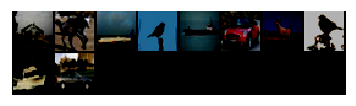

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

### Check labelling

Useful in case of random shuffling of labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


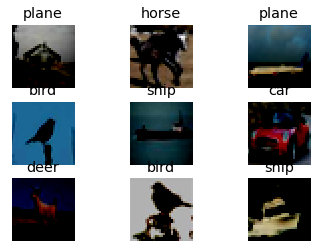

In [12]:
for i in range(9):
    plt.subplot(3,3,i+1)
    imshow(images[i,:])
    plt.title(classes[labels[i].item()])

In [13]:
def get_stats(loader):   
    '''
    Compute training statistics (loss and accuracy) on loader data
    '''
    loss = 0.0
    correct = 0
    total = 0       
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        l = loss.to('cpu').item()/total
        acc = 100 * correct/total
        return [l,acc]

# Initialize network, optimizer and loss

In [14]:
from cifar10_archs import Net
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [15]:
print(model)
print( summary(model, imgs_shape) )

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]            2416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]           48120
            Linear-6                   [-1, 84]           10164
            Linear-7                   [-1, 10]             850
Total params: tensor(62006)
T

In [ ]:
train_stats = []
test_stats  = []
fractions   = []
params_stats= []
grad_stats  = []
grad2_stats = []
snr_stats   = []

for epoch in tqdm(range(epochs)):
    
    # init to zero accumulators for grad and grad2
    grad  = init_grad(model)
    grad2 = init_grad(model)  
    
    count = 0
    
    for i, data in enumerate(train_loader, 0):
                               
        # get the inputs and load it on device
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)  
       
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()
                
        # accumulate grad and grad2
        grad  = acc_grad(grad,model)
        grad2 = acc_grad2(grad2,model)
        
        if (i + 1) % n == 0 :
            
            count += 1
            #print('Epoch : {} mini-epoch/tot : {}/{}'.format(epoch, count, n_lb) )
            
            with torch.no_grad():
                
                # compute the snr 
                snr = compute_snr(grad, grad2, n)

                # temper the grad with the information on grad2
                fr = []
                grad_copy = []
                                              
                for p, g, s in zip(model.parameters(), grad, snr): 
                    grad_copy.append(p.grad.clone())
                    
                    # This is the only line where the true gradient is touched
                    # it substitute the gradient p.grad (that is the one computed on
                    # the last mini-batch, since optimizer.zero_grad() is always called)
                    # with the gradient accumulated in acc_grad. This gradient is averaged
                    # over the number of mini-batches in a large batch, so it is divided
                    # by n.
                    
                    # If we use the modified SGD, when the signal to noise 
                    # ratio is > 1 we leave grad untouched, otherwise the gradient is 
                    # multiplied by the signal to noise ratio value
                    
                    if MODIFIED_SGD:
                        p.grad = torch.where(s > 1, g/n, s * g/n)          
                    else:
                        p.grad = g/n
                        
                    fr.append(  ( s < 1).sum().item() / 
                             torch.prod(torch.tensor( s.size() ) ).item()  )       
            fractions.append(fr)        
    
            # store statistics about params grad, grad2 and snr    
            params_stats.append([ [x.mean().item(), x.std().item()]  for x in model.parameters() ] )
            grad_stats.append(  [ [x.mean().item(), x.std().item()]  for x in grad] )
            grad2_stats.append( [ [x.mean().item(), x.std().item()]  for x in grad2] )
            snr_stats.append(   [ [x.mean().item(), x.std().item()]  for x in snr] )
        
            # this is called after the large batch of n mini-batches
            optimizer.step()
            
            # set to zero accumulators for grad and grad2
            grad  = init_grad(model)
            grad2 = init_grad(model)
            
                          
    # save model
    if SAVE:
        #model.save_state_dict(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        torch.save(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        
    # get statistics
    train_stats.append(get_stats(train_loader))
    test_stats.append(get_stats(test_loader))
        
    # print statistics
    print('Train loss : %g --- Train acc : %g %%' % ( train_stats[-1][0], train_stats[-1][1] )) 
    print('Test  loss : %g --- Test  acc : %g %%' % ( test_stats[-1][0],  test_stats[-1][1] ))         

  1%|          | 1/100 [00:13<22:21, 13.56s/it]

Train loss : 0.229675 --- Train acc : 12.612 %
Test  loss : 0.229666 --- Test  acc : 12.49 %


  2%|▏         | 2/100 [00:26<21:49, 13.36s/it]

Train loss : 0.222998 --- Train acc : 17.038 %
Test  loss : 0.222942 --- Test  acc : 17.17 %


  3%|▎         | 3/100 [00:40<21:34, 13.35s/it]

Train loss : 0.199799 --- Train acc : 27.702 %
Test  loss : 0.199866 --- Test  acc : 27.61 %


  4%|▍         | 4/100 [00:53<21:27, 13.41s/it]

Train loss : 0.191787 --- Train acc : 29.492 %
Test  loss : 0.191235 --- Test  acc : 30.61 %


  5%|▌         | 5/100 [01:07<21:15, 13.43s/it]

Train loss : 0.177528 --- Train acc : 35.538 %
Test  loss : 0.176931 --- Test  acc : 35.95 %


  6%|▌         | 6/100 [01:20<21:05, 13.47s/it]

Train loss : 0.17398 --- Train acc : 36.564 %
Test  loss : 0.173818 --- Test  acc : 37.23 %


  7%|▋         | 7/100 [01:34<20:51, 13.46s/it]

Train loss : 0.169415 --- Train acc : 38.028 %
Test  loss : 0.168781 --- Test  acc : 38.29 %


  8%|▊         | 8/100 [01:48<20:46, 13.54s/it]

Train loss : 0.167971 --- Train acc : 39.43 %
Test  loss : 0.168019 --- Test  acc : 39.51 %


  9%|▉         | 9/100 [02:01<20:31, 13.53s/it]

Train loss : 0.161918 --- Train acc : 41.146 %
Test  loss : 0.161969 --- Test  acc : 41.21 %


 10%|█         | 10/100 [02:16<20:24, 13.60s/it]

Train loss : 0.161768 --- Train acc : 41.296 %
Test  loss : 0.161771 --- Test  acc : 40.86 %


 11%|█         | 11/100 [02:29<20:10, 13.60s/it]

Train loss : 0.158469 --- Train acc : 42.802 %
Test  loss : 0.158837 --- Test  acc : 42.57 %


 12%|█▏        | 12/100 [02:42<19:54, 13.57s/it]

Train loss : 0.152256 --- Train acc : 44.426 %
Test  loss : 0.152499 --- Test  acc : 44.63 %


 13%|█▎        | 13/100 [02:56<19:41, 13.58s/it]

Train loss : 0.150862 --- Train acc : 45.302 %
Test  loss : 0.151252 --- Test  acc : 45.12 %


 14%|█▍        | 14/100 [03:10<19:30, 13.61s/it]

Train loss : 0.144757 --- Train acc : 47.602 %
Test  loss : 0.145817 --- Test  acc : 47.76 %


 15%|█▌        | 15/100 [03:24<19:18, 13.63s/it]

Train loss : 0.142489 --- Train acc : 48.612 %
Test  loss : 0.143654 --- Test  acc : 48.02 %


 16%|█▌        | 16/100 [03:38<19:07, 13.66s/it]

Train loss : 0.157784 --- Train acc : 42.912 %
Test  loss : 0.159095 --- Test  acc : 42.64 %


 17%|█▋        | 17/100 [03:52<18:54, 13.67s/it]

Train loss : 0.14 --- Train acc : 49.112 %
Test  loss : 0.14153 --- Test  acc : 48.56 %


 18%|█▊        | 18/100 [04:06<18:43, 13.70s/it]

Train loss : 0.134812 --- Train acc : 51.036 %
Test  loss : 0.136975 --- Test  acc : 50.14 %


 19%|█▉        | 19/100 [04:20<18:30, 13.71s/it]

Train loss : 0.13202 --- Train acc : 52.662 %
Test  loss : 0.134568 --- Test  acc : 50.92 %


 20%|██        | 20/100 [04:34<18:18, 13.73s/it]

Train loss : 0.133025 --- Train acc : 52.8 %
Test  loss : 0.135266 --- Test  acc : 51.63 %


 21%|██        | 21/100 [04:48<18:05, 13.74s/it]

Train loss : 0.128038 --- Train acc : 54.334 %
Test  loss : 0.131364 --- Test  acc : 52.7 %


 22%|██▏       | 22/100 [05:02<17:52, 13.75s/it]

Train loss : 0.130287 --- Train acc : 53.552 %
Test  loss : 0.134175 --- Test  acc : 51.68 %


 23%|██▎       | 23/100 [05:16<17:40, 13.77s/it]

Train loss : 0.124333 --- Train acc : 55.822 %
Test  loss : 0.128769 --- Test  acc : 53.88 %


 24%|██▍       | 24/100 [05:30<17:27, 13.79s/it]

Train loss : 0.126411 --- Train acc : 54.962 %
Test  loss : 0.130898 --- Test  acc : 52.96 %


In [ ]:
# save loss and accuracies in a dictionary
train_stats = np.asarray(train_stats)
test_stats  = np.asarray(test_stats)
fractions   = np.asarray(fractions)
params_stats= np.asarray(params_stats)
grad_stats  = np.asarray(grad_stats)
grad2_stats = np.asarray(grad2_stats)
snr_stats   = np.asarray(snr_stats)

tags = ['train_stats', 'test_stats', 'fractions', 'params_stats', 'grad_stats', 'grad2_stats', 'snr_stats' ]
vals = [train_stats, test_stats, fractions, params_stats, grad_stats, grad2_stats, snr_stats ]
training_data = dict(zip(tags, vals))
if SAVE:
    file = open( os.path.join( RES, 'training_data.pt') , 'wb' ) 
    pickle.dump(training_data,file)

In [ ]:
win = 30
nchecks = int( np.floor(len(train_loader.dataset)/(mb_size*n) ))
layer_names = [m[0] for idx,m in enumerate(model.named_modules()) ]
layer_names.remove('')
layer_names.remove('pool')
print(layer_names)

In [ ]:
def plot_results(figname, train_stats, test_stats, fractions, grad_stats, grad2_stats):

    fig = plt.figure(figsize=(20,20))
    plt.subplot(4,4,1)
    plt.plot(train_stats[:,0],'-',label='training loss')
    plt.plot(test_stats[:,0],'-',label='test loss')
    plt.xlabel('epoch')
    plt.title('loss')
    plt.legend()

    plt.subplot(4,4,2)
    plt.plot(train_stats[:,1],'-',label='training accuracy')
    plt.plot(test_stats[:,1],'-',label='test accuracy')
    plt.xlabel('epoch')
    plt.title('accuracy')
    plt.legend()

    plt.subplot(4,4,3)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean(fractions[:,i*2], win ),label=layer_names[i] ) 
    plt.legend()
    plt.xlabel('epoch')
    plt.title('fraction of $\eta < 1$')

    plt.subplot(4,4,4)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad_stats[:,i*2,0], win ),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad mean')

    plt.subplot(4,4,5)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad_stats[:,i*2,1], win ),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad std')

    plt.subplot(4,4,6)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad2_stats[:,i*2,0], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad2 mean')

    plt.subplot(4,4,7)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad2_stats[:,i*2,1], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad2 std')

    plt.subplot(4,4,8)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( snr_stats[:,i*2,0], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('snr mean')

    plt.subplot(4,4,9)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( snr_stats[:,i*2,1], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('snr std')

    plt.savefig(os.path.join(FIG, figname))
    
    plt.show()


In [ ]:
plot_results(DATASET, train_stats, test_stats, fractions, grad_stats, grad2_stats)